Project Brief : <br>
Predicting how many season a player play in the NBA based on their regular season stats

Case : <br>
Regression

Variable: <br>
Y : Seasons played <br>
X : games played percentage, minutes per game, point per game, assist per game, rebound per game, steal per game, block per game, field goal percentage, 3 point field goal percentage, free throw percentage

Set: <br>
Training : 80% of retired players data <br>
Testing : 20% of retired players data

Model: <br>
1. Linear Regression <br>
2. Decision Trees <br>
3. Random Forest <br>
4. Support Vector Regression <br>
5. Multi Layer Perceptron Regression
 


Import library

In [5]:
from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import playercareerstats

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import math
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras


import joblib

Get data

In [6]:
# all_players = players.get_players()

# all_stats = []

# for p in tqdm(all_players, desc="Fetching Players"):
#     try:
#         career = playercareerstats.PlayerCareerStats(player_id=p["id"])
#         df = career.get_data_frames()[0]
#         df["full_name"] = p["full_name"]
#         all_stats.append(df)

#     except Exception as e:
#         print(f"Failed for {p['full_name']}: {e}")

# df_all_players = pd.concat(all_stats, ignore_index=True)

# df_all_players

Save data

In [7]:
# df_all_players.to_csv("all_players_stats.csv", index=False)

See raw data

In [8]:
df_raw = pd.read_csv("all_players_stats.csv")
df_raw

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,full_name
0,76001,1990-91,0,1610612757,POR,23.0,43,0.0,290.0,55,...,27.0,62.0,89.0,12,4.0,12.0,22.0,39,135,Alaa Abdelnaby
1,76001,1991-92,0,1610612757,POR,24.0,71,1.0,934.0,178,...,81.0,179.0,260.0,30,25.0,16.0,66.0,132,432,Alaa Abdelnaby
2,76001,1992-93,0,1610612749,MIL,25.0,12,0.0,159.0,26,...,12.0,25.0,37.0,10,6.0,4.0,13.0,24,64,Alaa Abdelnaby
3,76001,1992-93,0,1610612738,BOS,25.0,63,52.0,1152.0,219,...,114.0,186.0,300.0,17,19.0,22.0,84.0,165,514,Alaa Abdelnaby
4,76001,1992-93,0,0,TOT,25.0,75,52.0,1311.0,245,...,126.0,211.0,337.0,27,25.0,26.0,97.0,189,578,Alaa Abdelnaby
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30212,203967,2022-23,0,1610612756,PHX,29.0,37,12.0,533.0,76,...,39.0,103.0,142.0,57,13.0,5.0,36.0,69,215,Dario Šarić
30213,203967,2022-23,0,1610612760,OKC,29.0,20,0.0,273.0,51,...,14.0,51.0,65.0,17,7.0,2.0,19.0,30,147,Dario Šarić
30214,203967,2022-23,0,0,TOT,29.0,57,12.0,806.0,127,...,53.0,154.0,207.0,74,20.0,7.0,55.0,99,362,Dario Šarić
30215,203967,2023-24,0,1610612744,GSW,30.0,64,9.0,1098.0,181,...,73.0,210.0,283.0,144,31.0,10.0,78.0,112,515,Dario Šarić


See all players that we unable to fetch

In [9]:
df_all_players = pd.DataFrame(players.get_players())

id_raw = set(df_raw["PLAYER_ID"].unique())
id_all_players = set(df_all_players["id"].unique())

missing_players = id_all_players - id_raw

df_missing_players = df_all_players[df_all_players["id"].isin(missing_players)]
df_missing_players

,id,full_name,first_name,last_name,is_active
36,1631231,James Akinjo,James,Akinjo,True
38,1629152,DeVaughn Akoon-Purcell,DeVaughn,Akoon-Purcell,False
56,1629638,Nickeil Alexander-Walker,Nickeil,Alexander-Walker,True
69,1641851,Timmy Allen,Timmy,Allen,False
77,1824,Peter Aluma,Peter,Aluma,False
...,...,...,...,...,...
4972,203203,Chris Wright,Chris,Wright,False
4996,1642385,Cui Yongxi,Cui,Yongxi,True
5001,1748,Korleone Young,Korleone,Young,False
5016,202545,Luke Zeller,Luke,Zeller,False


Remove unneccesary columns

In [10]:
df_all = df_raw.drop(columns=["LEAGUE_ID", "TEAM_ID", "GS"])

Rename columns

In [11]:
df_all = df_all.rename(columns={
    "PLAYER_ID": "id",
    "full_name": "name",
    "SEASON_ID": "season",
    "TEAM_ABBREVIATION": "team",
    "PLAYER_AGE": "age",
    "GP": "games_played",
    "MIN": "total_minutes",
    "PTS": "total_points",
    "AST": "total_assist",
    "REB": "total_rebounds",
    "STL": "total_steals",
    "BLK": "total_blocks",
    "FGM": "total_field_goal_made",
    "FGA": "total_field_goal_attempt",
    "FG_PCT": "field_goal_percentage",
    "FG3M": "total_3point_field_goal_made",
    "FG3A": "total_3point_field_goal_attempt",
    "FG3_PCT": "3point_field_goal_percentage",
    "FTM": "total_free_throw_made",
    "FTA": "total_free_throw_attempt",
    "FT_PCT": "free_throw_percentage",
    "OREB": "total_offensive_rebound",
    "DREB": "total_defensive_rebound",
    "TOV": "total_turnover",
    "PF": "total_fouls"
})

Change season column

In [12]:
def fix_season(season):
    start, end = season.split("-")
    end_yr = int(end)
    if end_yr <=30:
        return 2000 + end_yr
    else:
        return 1900 + end_yr

df_all["season"] = df_all["season"].apply(fix_season)

Make a "games played percentage" column

In [13]:
# make a season games column

season_exception = {
    1999: 50,
    2012: 66,
    2020: 71,
    2021: 72
}

df_all["season_games"] = 82
df_all["season_games"] = df_all["season"].apply(lambda x: season_exception.get(x, 82))

In [14]:
# count games_played_percentage

df_all["games_played_percentage"] = ((df_all["games_played"] / df_all["season_games"]) * 100).round(0)

Change field goal percentage, 3 point field goal percentage, and free throw percentage column to %

In [15]:
df_all["field_goal_percentage"] = (df_all["field_goal_percentage"] * 100).round(0)
df_all["3point_field_goal_percentage"] = (df_all["3point_field_goal_percentage"] * 100).round(0)
df_all["free_throw_percentage"] = (df_all["free_throw_percentage"] * 100).round(0)

Change order of columns

In [16]:
total_cols = ["id", "name","team", "age", "season", "season_games", "games_played", "games_played_percentage","total_minutes", "total_points", "total_assist", "total_rebounds", "total_steals",
         "total_blocks", "total_field_goal_made", "total_field_goal_attempt", "field_goal_percentage", "total_3point_field_goal_made", "total_3point_field_goal_attempt", 
         "3point_field_goal_percentage", "total_free_throw_made","total_free_throw_attempt", "free_throw_percentage", "total_offensive_rebound", "total_defensive_rebound", "total_turnover", "total_fouls"]

total_cols = [c for c in total_cols if c in df_all.columns]

df_all = df_all[total_cols]

Check NA data

In [17]:
df_all.isna().sum()

id                                    0
name                                  0
team                                  8
age                                   0
season                                0
season_games                          0
games_played                          0
games_played_percentage               0
total_minutes                       766
total_points                          0
total_assist                          0
total_rebounds                      655
total_steals                       4145
total_blocks                       4145
total_field_goal_made                 0
total_field_goal_attempt              0
field_goal_percentage                14
total_3point_field_goal_made       6006
total_3point_field_goal_attempt    6006
3point_field_goal_percentage       6227
total_free_throw_made                 0
total_free_throw_attempt              0
free_throw_percentage               119
total_offensive_rebound            4145
total_defensive_rebound            4145


Change year from 1980 so it is more relevant and for stats counting purposes

In [18]:
df_all = df_all[df_all["season"] >= 1980]

Check NA data (2)

In [19]:
df_all.isna().sum()

id                                   0
name                                 0
team                                 0
age                                  0
season                               0
season_games                         0
games_played                         0
games_played_percentage              0
total_minutes                        0
total_points                         0
total_assist                         0
total_rebounds                       0
total_steals                         0
total_blocks                         0
total_field_goal_made                0
total_field_goal_attempt             0
field_goal_percentage                1
total_3point_field_goal_made         0
total_3point_field_goal_attempt      0
3point_field_goal_percentage       221
total_free_throw_made                0
total_free_throw_attempt             0
free_throw_percentage               23
total_offensive_rebound              0
total_defensive_rebound              0
total_turnover           

Investigate NA data - field goal percentage

In [20]:
df_all[df_all["field_goal_percentage"].isna()]

,id,name,team,age,season,season_games,games_played,games_played_percentage,total_minutes,total_points,...,total_3point_field_goal_made,total_3point_field_goal_attempt,3point_field_goal_percentage,total_free_throw_made,total_free_throw_attempt,free_throw_percentage,total_offensive_rebound,total_defensive_rebound,total_turnover,total_fouls
14589,77214,Yvon Joseph,NJN,28.0,1986,82,1,1.0,5.0,2,...,0.0,0.0,NaN,2,2,100.0,0.0,0.0,0.0,1


In [21]:
# fill field_goal_percentage NA values

df_all["field_goal_percentage"] = df_all.apply(
    lambda row: 0 if pd.isna(row["field_goal_percentage"]) and row["total_field_goal_made"] == 0 and row["total_field_goal_attempt"] == 0
    else row["field_goal_percentage"], axis=1
)

Investigate NA data - 3 point field goal percentage

In [22]:
df_all[df_all["3point_field_goal_percentage"].isna()]

,id,name,team,age,season,season_games,games_played,games_played_percentage,total_minutes,total_points,...,total_3point_field_goal_made,total_3point_field_goal_attempt,3point_field_goal_percentage,total_free_throw_made,total_free_throw_attempt,free_throw_percentage,total_offensive_rebound,total_defensive_rebound,total_turnover,total_fouls
1499,76104,Marvin Barnes,SDC,27.0,1980,82,20,24.0,287.0,64,...,0.0,0.0,NaN,16,32,50.0,34.0,43.0,18.0,52
1698,76120,Tim Bassett,TOT,29.0,1980,82,12,15.0,164.0,34,...,0.0,0.0,NaN,10,15,67.0,11.0,22.0,9.0,27
1989,76140,Ron Behagen,WAS,29.0,1980,82,6,7.0,64.0,23,...,0.0,0.0,NaN,5,6,83.0,6.0,8.0,4.0,14
2133,76151,Mel Bennett,CLE,27.0,1982,82,3,4.0,23.0,5,...,0.0,0.0,NaN,1,6,17.0,1.0,2.0,4.0,2
2407,76174,Norman Black,DET,23.0,1981,82,3,4.0,28.0,8,...,0.0,0.0,NaN,2,8,25.0,0.0,2.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29890,78618,Sam Worthen,UTH,24.0,1982,82,5,6.0,22.0,4,...,0.0,0.0,NaN,0,0,NaN,1.0,0.0,2.0,3
29978,78623,Larry Wright,DET,27.0,1982,82,1,1.0,6.0,0,...,0.0,0.0,NaN,0,0,NaN,0.0,0.0,1.0,2
30039,78632,Rich Yonakor,SAN,23.0,1982,82,10,12.0,70.0,33,...,0.0,0.0,NaN,5,7,71.0,13.0,14.0,2.0,7
30062,78634,Michael Young,PHL,25.0,1986,82,2,2.0,2.0,0,...,0.0,0.0,NaN,0,0,NaN,0.0,0.0,0.0,0


In [23]:
# fill 3point_field_goal_percentage NA values

df_all["3point_field_goal_percentage"] = df_all.apply(
    lambda row: 0 if pd.isna(row["3point_field_goal_percentage"]) and row["total_3point_field_goal_made"] == 0 and row["total_3point_field_goal_attempt"] == 0
    else row["3point_field_goal_percentage"], axis=1
)

Investigate NA data - free throw percentage

In [24]:
df_all[df_all["free_throw_percentage"].isna()]

,id,name,team,age,season,season_games,games_played,games_played_percentage,total_minutes,total_points,...,total_3point_field_goal_made,total_3point_field_goal_attempt,3point_field_goal_percentage,total_free_throw_made,total_free_throw_attempt,free_throw_percentage,total_offensive_rebound,total_defensive_rebound,total_turnover,total_fouls
3343,76261,David Britton,WAS,22.0,1981,82,2,2.0,9.0,4,...,0.0,0.0,0.0,0,0,NaN,0.0,2.0,2.0,2
3651,76286,Roger Brown,CHI,30.0,1980,82,4,5.0,37.0,2,...,0.0,0.0,0.0,0,0,NaN,2.0,8.0,0.0,4
5582,76443,Joe Cooper,NJN,24.0,1982,82,1,1.0,11.0,2,...,0.0,0.0,0.0,0,0,NaN,1.0,1.0,1.0,2
10466,76884,Claude Gregory,WAS,27.0,1986,82,2,2.0,2.0,2,...,0.0,0.0,0.0,0,0,NaN,2.0,0.0,2.0,1
11713,76992,Jerome Henderson,LAL,26.0,1986,82,1,1.0,3.0,4,...,0.0,0.0,0.0,0,0,NaN,0.0,1.0,0.0,1
13208,77107,Ralph Jackson,IND,22.0,1985,82,1,1.0,12.0,2,...,0.0,0.0,0.0,0,0,NaN,1.0,0.0,1.0,1
13252,77100,Tony Jackson,LAL,23.0,1981,82,2,2.0,14.0,2,...,0.0,0.0,0.0,0,0,NaN,0.0,2.0,0.0,1
14271,77183,Earl Jones,LAL,24.0,1985,82,2,2.0,7.0,0,...,0.0,0.0,0.0,0,0,NaN,0.0,0.0,1.0,0
14384,77191,Ozell Jones,LAC,25.0,1986,82,3,4.0,18.0,0,...,0.0,0.0,0.0,0,0,NaN,0.0,2.0,3.0,5
17592,77515,Keith McCord,WAS,24.0,1981,82,2,2.0,9.0,4,...,0.0,0.0,0.0,0,0,NaN,1.0,1.0,2.0,0


In [25]:
# fill free_throw_percentage NA values

df_all["free_throw_percentage"] = df_all.apply(
    lambda row: 0 if pd.isna(row["free_throw_percentage"]) and row["total_free_throw_made"] == 0 and row["total_free_throw_attempt"] == 0
    else row["free_throw_percentage"], axis=1
)

Check NA data (3)

In [26]:
df_all.isna().sum()

id                                 0
name                               0
team                               0
age                                0
season                             0
season_games                       0
games_played                       0
games_played_percentage            0
total_minutes                      0
total_points                       0
total_assist                       0
total_rebounds                     0
total_steals                       0
total_blocks                       0
total_field_goal_made              0
total_field_goal_attempt           0
field_goal_percentage              0
total_3point_field_goal_made       0
total_3point_field_goal_attempt    0
3point_field_goal_percentage       0
total_free_throw_made              0
total_free_throw_attempt           0
free_throw_percentage              0
total_offensive_rebound            0
total_defensive_rebound            0
total_turnover                     0
total_fouls                        0
d

Change team names

In [27]:
change_teams_names = {
    "GOS": "GSW",
    "CHH": "CHA",
    "VAN": "MEM",
    "NOH": "NOP",
    "SEA": "OKC",
    "NOK": "NOP",
    "SDC": "LAC",
    "KCK": "SAC",
    "NJN": "BKN",
    "PHL": "PHI",
    "UTH": "UTA",
    "SAN": "SAS"

}

df_all["team"] = df_all["team"].replace(change_teams_names)

Convert total stats columns to integer

In [28]:
df_all = df_all.apply(lambda col: col.astype(int) if col.dtype == "float64" else col)

See player that got duplicate data (traded mid-season)

In [29]:
dup_players = df_all[df_all.duplicated(subset=["season", "id"], keep=False)]
dup_players.sort_values(["season", "id"])

,id,name,team,age,season,season_games,games_played,games_played_percentage,total_minutes,total_points,...,total_3point_field_goal_made,total_3point_field_goal_attempt,3point_field_goal_percentage,total_free_throw_made,total_free_throw_attempt,free_throw_percentage,total_offensive_rebound,total_defensive_rebound,total_turnover,total_fouls
1696,76120,Tim Bassett,SAS,29,1980,82,5,6,72,10,...,0,0,0,2,3,67,4,11,5,13
1697,76120,Tim Bassett,BKN,29,1980,82,7,9,92,24,...,0,0,0,8,12,67,7,11,4,14
1698,76120,Tim Bassett,TOT,29,1980,82,12,15,164,34,...,0,0,0,10,15,67,11,22,9,27
2153,76154,Kent Benson,MIL,25,1980,82,56,68,1389,492,...,0,1,0,66,97,68,96,237,106,178
2154,76154,Kent Benson,DET,25,1980,82,17,21,502,206,...,1,4,25,33,44,75,30,90,51,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22420,1642024,Alex Reese,PHI,26,2025,82,14,17,214,74,...,15,41,37,9,12,75,8,38,6,21
22421,1642024,Alex Reese,TOT,26,2025,82,15,18,216,76,...,15,41,37,9,12,75,9,38,6,21
13560,1642358,AJ Johnson,MIL,20,2025,82,7,9,44,20,...,3,5,60,1,2,50,0,7,4,0
13561,1642358,AJ Johnson,WAS,20,2025,82,22,27,595,200,...,21,85,25,31,35,89,8,44,31,50


Combine data (player that is not traded + player that is traded but with total stats (TOT))

In [30]:
trade = df_all[df_all["team"] == "TOT"]
no_trade = df_all[~df_all["team"].isin(["trade"])]

df_all = pd.concat([trade, no_trade])
df_all = df_all.drop_duplicates(subset=["season", "id"], keep="first")

df_all

,id,name,team,age,season,season_games,games_played,games_played_percentage,total_minutes,total_points,...,total_3point_field_goal_made,total_3point_field_goal_attempt,3point_field_goal_percentage,total_free_throw_made,total_free_throw_attempt,free_throw_percentage,total_offensive_rebound,total_defensive_rebound,total_turnover,total_fouls
4,76001,Alaa Abdelnaby,TOT,25,1993,82,75,91,1311,578,...,0,1,0,88,116,76,126,211,97,189
8,76001,Alaa Abdelnaby,TOT,27,1995,82,54,66,506,256,...,0,2,0,20,35,57,37,77,45,104
56,1505,Tariq Abdul-Wahad,TOT,25,2000,82,61,74,1578,697,...,3,23,13,146,193,76,101,190,106,147
60,1505,Tariq Abdul-Wahad,TOT,27,2002,82,24,29,442,135,...,1,2,50,24,33,73,41,43,27,56
71,949,Shareef Abdur-Rahim,TOT,27,2004,82,85,104,2684,1384,...,9,34,26,373,429,87,189,450,184,222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30206,203967,Dario Šarić,PHI,24,2018,82,78,95,2310,1141,...,157,399,39,178,207,86,154,366,148,160
30210,203967,Dario Šarić,PHX,26,2020,71,66,93,1632,704,...,84,235,36,108,128,84,100,306,88,156
30211,203967,Dario Šarić,PHX,27,2021,72,50,69,871,437,...,47,135,35,84,99,85,46,144,57,95
30215,203967,Dario Šarić,GSW,30,2024,82,64,78,1098,515,...,74,197,38,79,93,85,73,210,78,112


Make per game averages

In [31]:
avg_cols = ["total_minutes", "total_points", "total_assist", "total_rebounds", "total_steals", "total_blocks", "total_field_goal_made", "total_field_goal_attempt", "total_3point_field_goal_made", "total_3point_field_goal_attempt", "total_free_throw_made", "total_free_throw_attempt", "total_offensive_rebound", "total_defensive_rebound", "total_turnover", "total_fouls"]

for column in avg_cols:
    df_all[f"avg_{column}"] = df_all[column] / df_all["games_played"]

df_all

,id,name,team,age,season,season_games,games_played,games_played_percentage,total_minutes,total_points,...,avg_total_field_goal_made,avg_total_field_goal_attempt,avg_total_3point_field_goal_made,avg_total_3point_field_goal_attempt,avg_total_free_throw_made,avg_total_free_throw_attempt,avg_total_offensive_rebound,avg_total_defensive_rebound,avg_total_turnover,avg_total_fouls
4,76001,Alaa Abdelnaby,TOT,25,1993,82,75,91,1311,578,...,3.266667,6.306667,0.000000,0.013333,1.173333,1.546667,1.680000,2.813333,1.293333,2.520000
8,76001,Alaa Abdelnaby,TOT,27,1995,82,54,66,506,256,...,2.185185,4.277778,0.000000,0.037037,0.370370,0.648148,0.685185,1.425926,0.833333,1.925926
56,1505,Tariq Abdul-Wahad,TOT,25,2000,82,61,74,1578,697,...,4.491803,10.590164,0.049180,0.377049,2.393443,3.163934,1.655738,3.114754,1.737705,2.409836
60,1505,Tariq Abdul-Wahad,TOT,27,2002,82,24,29,442,135,...,2.291667,6.125000,0.041667,0.083333,1.000000,1.375000,1.708333,1.791667,1.125000,2.333333
71,949,Shareef Abdur-Rahim,TOT,27,2004,82,85,104,2684,1384,...,5.894118,12.400000,0.105882,0.400000,4.388235,5.047059,2.223529,5.294118,2.164706,2.611765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30206,203967,Dario Šarić,PHI,24,2018,82,78,95,2310,1141,...,5.166667,11.410256,2.012821,5.115385,2.282051,2.653846,1.974359,4.692308,1.897436,2.051282
30210,203967,Dario Šarić,PHX,26,2020,71,66,93,1632,704,...,3.878788,8.151515,1.272727,3.560606,1.636364,1.939394,1.515152,4.636364,1.333333,2.363636
30211,203967,Dario Šarić,PHX,27,2021,72,50,69,871,437,...,3.060000,6.840000,0.940000,2.700000,1.680000,1.980000,0.920000,2.880000,1.140000,1.900000
30215,203967,Dario Šarić,GSW,30,2024,82,64,78,1098,515,...,2.828125,6.062500,1.156250,3.078125,1.234375,1.453125,1.140625,3.281250,1.218750,1.750000


Rename columns (2)

In [32]:
df_all = df_all.rename(columns={
    "avg_total_minutes": "minutes_per_game",
    "avg_total_points": "point_per_game",
    "avg_total_assist": "assist_per_game",
    "avg_total_rebounds": "rebound_per_game",
    "avg_total_steals": "steal_per_game",
    "avg_total_blocks": "block_per_game",
    "avg_total_field_goal_made": "field_goal_made_per_game",
    "avg_total_field_goal_attempt": "field_goal_attempt_per_game",
    "avg_total_3point_field_goal_made": "3point_field_goal_made_per_game",
    "avg_total_3point_field_goal_attempt": "3point_field_goal_attempt_per_game",
    "avg_total_free_throw_made": "free_throw_made_per_game",
    "avg_total_free_throw_attempt": "free_throw_attempt_per_game",
    "avg_total_offensive_rebound": "offensive_rebound_per_game",
    "avg_total_defensive_rebound": "defensive_rebound_per_game",
    "avg_total_turnover": "turnover_per_game",
    "avg_total_fouls": "foul_per_game"
})

Make new dataframe containing all per game stats

In [33]:
avg = [
    "games_played_percentage", "minutes_per_game", "point_per_game", "assist_per_game", "rebound_per_game", "steal_per_game", "block_per_game", "field_goal_percentage", "3point_field_goal_percentage", "free_throw_percentage"  
]

df_avg = df_all[["id", "name", "season", "age"] + avg].copy()

df_avg

,id,name,season,age,games_played_percentage,minutes_per_game,point_per_game,assist_per_game,rebound_per_game,steal_per_game,block_per_game,field_goal_percentage,3point_field_goal_percentage,free_throw_percentage
4,76001,Alaa Abdelnaby,1993,25,91,17.480000,7.706667,0.360000,4.493333,0.333333,0.346667,52,0,76
8,76001,Alaa Abdelnaby,1995,27,66,9.370370,4.740741,0.240741,2.111111,0.277778,0.222222,51,0,57
56,1505,Tariq Abdul-Wahad,2000,25,74,25.868852,11.426230,1.606557,4.770492,0.967213,0.459016,42,13,76
60,1505,Tariq Abdul-Wahad,2002,27,29,18.416667,5.625000,1.000000,3.500000,0.833333,0.416667,37,50,73
71,949,Shareef Abdur-Rahim,2004,27,104,31.576471,16.282353,2.047059,7.517647,0.800000,0.435294,48,26,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30206,203967,Dario Šarić,2018,24,95,29.615385,14.628205,2.589744,6.666667,0.653846,0.256410,45,39,86
30210,203967,Dario Šarić,2020,26,93,24.727273,10.666667,1.863636,6.151515,0.560606,0.242424,48,36,84
30211,203967,Dario Šarić,2021,27,69,17.420000,8.740000,1.300000,3.800000,0.600000,0.080000,45,35,85
30215,203967,Dario Šarić,2024,30,78,17.156250,8.046875,2.250000,4.421875,0.484375,0.156250,47,38,85


Make one player stats just one row

In [34]:
df_one = df_avg.groupby(["id", "name"])[avg].mean().reset_index()
df_one

,id,name,games_played_percentage,minutes_per_game,point_per_game,assist_per_game,rebound_per_game,steal_per_game,block_per_game,field_goal_percentage,3point_field_goal_percentage,free_throw_percentage
0,2,Byron Scott,93.571429,27.979183,14.016401,2.539436,2.759450,1.133646,0.255741,47.571429,36.500000,82.928571
1,3,Grant Long,84.133333,27.165805,8.778321,1.592694,5.814659,1.131856,0.338852,45.466667,16.933333,75.600000
2,7,Dan Schayes,77.944444,17.868083,6.893281,1.009136,4.514380,0.457244,0.665776,45.277778,7.388889,79.888889
3,9,Sedale Threatt,82.928571,22.585385,9.216364,3.580243,1.730210,1.132404,0.138975,47.285714,24.642857,80.428571
4,12,Chris King,44.000000,11.702778,4.030556,0.719444,1.979167,0.455556,0.179167,37.333333,22.666667,41.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
3477,1642449,Tolu Smith,1.000000,22.000000,14.000000,0.000000,8.000000,0.000000,0.000000,67.000000,0.000000,67.000000
3478,1642450,Daniss Jenkins,9.000000,3.285714,1.000000,0.428571,0.285714,0.000000,0.000000,30.000000,14.000000,0.000000
3479,1642461,Spencer Jones,24.000000,6.250000,1.300000,0.250000,0.850000,0.250000,0.250000,32.000000,6.000000,100.000000
3480,1642505,Alex Ducas,26.000000,5.952381,1.714286,0.238095,1.238095,0.238095,0.000000,40.000000,48.000000,100.000000


Make "season played" column

In [35]:
season_counts = df_all.groupby(["id", "name"])["season"].nunique().reset_index(name="season_played")

df_one = df_one.merge(season_counts, on=["id", "name"], how="left")

df_one

,id,name,games_played_percentage,minutes_per_game,point_per_game,assist_per_game,rebound_per_game,steal_per_game,block_per_game,field_goal_percentage,3point_field_goal_percentage,free_throw_percentage,season_played
0,2,Byron Scott,93.571429,27.979183,14.016401,2.539436,2.759450,1.133646,0.255741,47.571429,36.500000,82.928571,14
1,3,Grant Long,84.133333,27.165805,8.778321,1.592694,5.814659,1.131856,0.338852,45.466667,16.933333,75.600000,15
2,7,Dan Schayes,77.944444,17.868083,6.893281,1.009136,4.514380,0.457244,0.665776,45.277778,7.388889,79.888889,18
3,9,Sedale Threatt,82.928571,22.585385,9.216364,3.580243,1.730210,1.132404,0.138975,47.285714,24.642857,80.428571,14
4,12,Chris King,44.000000,11.702778,4.030556,0.719444,1.979167,0.455556,0.179167,37.333333,22.666667,41.333333,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3477,1642449,Tolu Smith,1.000000,22.000000,14.000000,0.000000,8.000000,0.000000,0.000000,67.000000,0.000000,67.000000,1
3478,1642450,Daniss Jenkins,9.000000,3.285714,1.000000,0.428571,0.285714,0.000000,0.000000,30.000000,14.000000,0.000000,1
3479,1642461,Spencer Jones,24.000000,6.250000,1.300000,0.250000,0.850000,0.250000,0.250000,32.000000,6.000000,100.000000,1
3480,1642505,Alex Ducas,26.000000,5.952381,1.714286,0.238095,1.238095,0.238095,0.000000,40.000000,48.000000,100.000000,1


Change order of columns (2)

In [36]:
final_cols = ["id", "name", "games_played_percentage", "minutes_per_game", "point_per_game", "assist_per_game", "rebound_per_game", "steal_per_game", "block_per_game", "field_goal_percentage", "3point_field_goal_percentage", "free_throw_percentage", "season_played"]

final_cols = [c for c in final_cols if c in df_one.columns]

df_one = df_one[final_cols]

Round float data

In [37]:
df_one = df_one.apply(lambda x: x.round(1) if x.dtype == "float64" else x)

See active & retired players

In [38]:
df = df_one.merge(df_all_players, on="id", how="inner")
df = df.drop(columns=["full_name", "first_name", "last_name"])

In [39]:
# retired players
df_retired = df[df["is_active"] == False].copy()

In [40]:
# active players
df_active = df[df["is_active"] == True].copy()

Data summarization <br>

df_avg = player per game stats per season (for data visualization purposes) <br>
df = all players per game stats <br>
df_retired = retired players per game stats <br>
df_active = active players per game stats

In [41]:
df_avg

,id,name,season,age,games_played_percentage,minutes_per_game,point_per_game,assist_per_game,rebound_per_game,steal_per_game,block_per_game,field_goal_percentage,3point_field_goal_percentage,free_throw_percentage
4,76001,Alaa Abdelnaby,1993,25,91,17.480000,7.706667,0.360000,4.493333,0.333333,0.346667,52,0,76
8,76001,Alaa Abdelnaby,1995,27,66,9.370370,4.740741,0.240741,2.111111,0.277778,0.222222,51,0,57
56,1505,Tariq Abdul-Wahad,2000,25,74,25.868852,11.426230,1.606557,4.770492,0.967213,0.459016,42,13,76
60,1505,Tariq Abdul-Wahad,2002,27,29,18.416667,5.625000,1.000000,3.500000,0.833333,0.416667,37,50,73
71,949,Shareef Abdur-Rahim,2004,27,104,31.576471,16.282353,2.047059,7.517647,0.800000,0.435294,48,26,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30206,203967,Dario Šarić,2018,24,95,29.615385,14.628205,2.589744,6.666667,0.653846,0.256410,45,39,86
30210,203967,Dario Šarić,2020,26,93,24.727273,10.666667,1.863636,6.151515,0.560606,0.242424,48,36,84
30211,203967,Dario Šarić,2021,27,69,17.420000,8.740000,1.300000,3.800000,0.600000,0.080000,45,35,85
30215,203967,Dario Šarić,2024,30,78,17.156250,8.046875,2.250000,4.421875,0.484375,0.156250,47,38,85


In [42]:
df

,id,name,games_played_percentage,minutes_per_game,point_per_game,assist_per_game,rebound_per_game,steal_per_game,block_per_game,field_goal_percentage,3point_field_goal_percentage,free_throw_percentage,season_played,is_active
0,2,Byron Scott,93.6,28.0,14.0,2.5,2.8,1.1,0.3,47.6,36.5,82.9,14,False
1,3,Grant Long,84.1,27.2,8.8,1.6,5.8,1.1,0.3,45.5,16.9,75.6,15,False
2,7,Dan Schayes,77.9,17.9,6.9,1.0,4.5,0.5,0.7,45.3,7.4,79.9,18,False
3,9,Sedale Threatt,82.9,22.6,9.2,3.6,1.7,1.1,0.1,47.3,24.6,80.4,14,False
4,12,Chris King,44.0,11.7,4.0,0.7,2.0,0.5,0.2,37.3,22.7,41.3,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3477,1642449,Tolu Smith,1.0,22.0,14.0,0.0,8.0,0.0,0.0,67.0,0.0,67.0,1,True
3478,1642450,Daniss Jenkins,9.0,3.3,1.0,0.4,0.3,0.0,0.0,30.0,14.0,0.0,1,True
3479,1642461,Spencer Jones,24.0,6.2,1.3,0.2,0.8,0.2,0.2,32.0,6.0,100.0,1,True
3480,1642505,Alex Ducas,26.0,6.0,1.7,0.2,1.2,0.2,0.0,40.0,48.0,100.0,1,True


In [43]:
df_retired

,id,name,games_played_percentage,minutes_per_game,point_per_game,assist_per_game,rebound_per_game,steal_per_game,block_per_game,field_goal_percentage,3point_field_goal_percentage,free_throw_percentage,season_played,is_active
0,2,Byron Scott,93.6,28.0,14.0,2.5,2.8,1.1,0.3,47.6,36.5,82.9,14,False
1,3,Grant Long,84.1,27.2,8.8,1.6,5.8,1.1,0.3,45.5,16.9,75.6,15,False
2,7,Dan Schayes,77.9,17.9,6.9,1.0,4.5,0.5,0.7,45.3,7.4,79.9,18,False
3,9,Sedale Threatt,82.9,22.6,9.2,3.6,1.7,1.1,0.1,47.3,24.6,80.4,14,False
4,12,Chris King,44.0,11.7,4.0,0.7,2.0,0.5,0.2,37.3,22.7,41.3,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3343,1631338,Mouhamadou Gueye,13.0,10.9,2.4,0.5,2.1,0.3,1.6,29.0,0.0,44.0,1,False
3348,1631495,Donovan Williams,2.0,2.0,2.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,1,False
3349,1641645,Xavier Cooks,12.0,12.6,3.8,0.6,3.8,0.6,0.4,61.0,0.0,40.0,1,False
3405,1641788,Alex Fudge,7.0,6.7,2.5,0.0,0.8,0.5,0.0,40.0,20.0,100.0,1,False


In [44]:
df_active

,id,name,games_played_percentage,minutes_per_game,point_per_game,assist_per_game,rebound_per_game,steal_per_game,block_per_game,field_goal_percentage,3point_field_goal_percentage,free_throw_percentage,season_played,is_active
933,2544,LeBron James,88.3,37.6,27.0,7.4,7.5,1.5,0.7,50.8,34.9,73.5,22,True
1905,101108,Chris Paul,84.8,33.6,17.0,9.2,4.4,2.0,0.2,46.6,36.8,87.2,20,True
2006,200768,Kyle Lowry,76.9,30.5,13.4,5.9,4.2,1.3,0.3,41.7,35.5,82.5,19,True
2017,200782,P.J. Tucker,78.8,25.7,5.8,1.2,4.8,0.9,0.3,42.4,34.7,70.6,14,True
2054,201142,Kevin Durant,82.1,36.4,27.2,4.5,7.0,1.0,1.1,50.7,39.0,87.9,17,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3477,1642449,Tolu Smith,1.0,22.0,14.0,0.0,8.0,0.0,0.0,67.0,0.0,67.0,1,True
3478,1642450,Daniss Jenkins,9.0,3.3,1.0,0.4,0.3,0.0,0.0,30.0,14.0,0.0,1,True
3479,1642461,Spencer Jones,24.0,6.2,1.3,0.2,0.8,0.2,0.2,32.0,6.0,100.0,1,True
3480,1642505,Alex Ducas,26.0,6.0,1.7,0.2,1.2,0.2,0.0,40.0,48.0,100.0,1,True


Histogram for all players

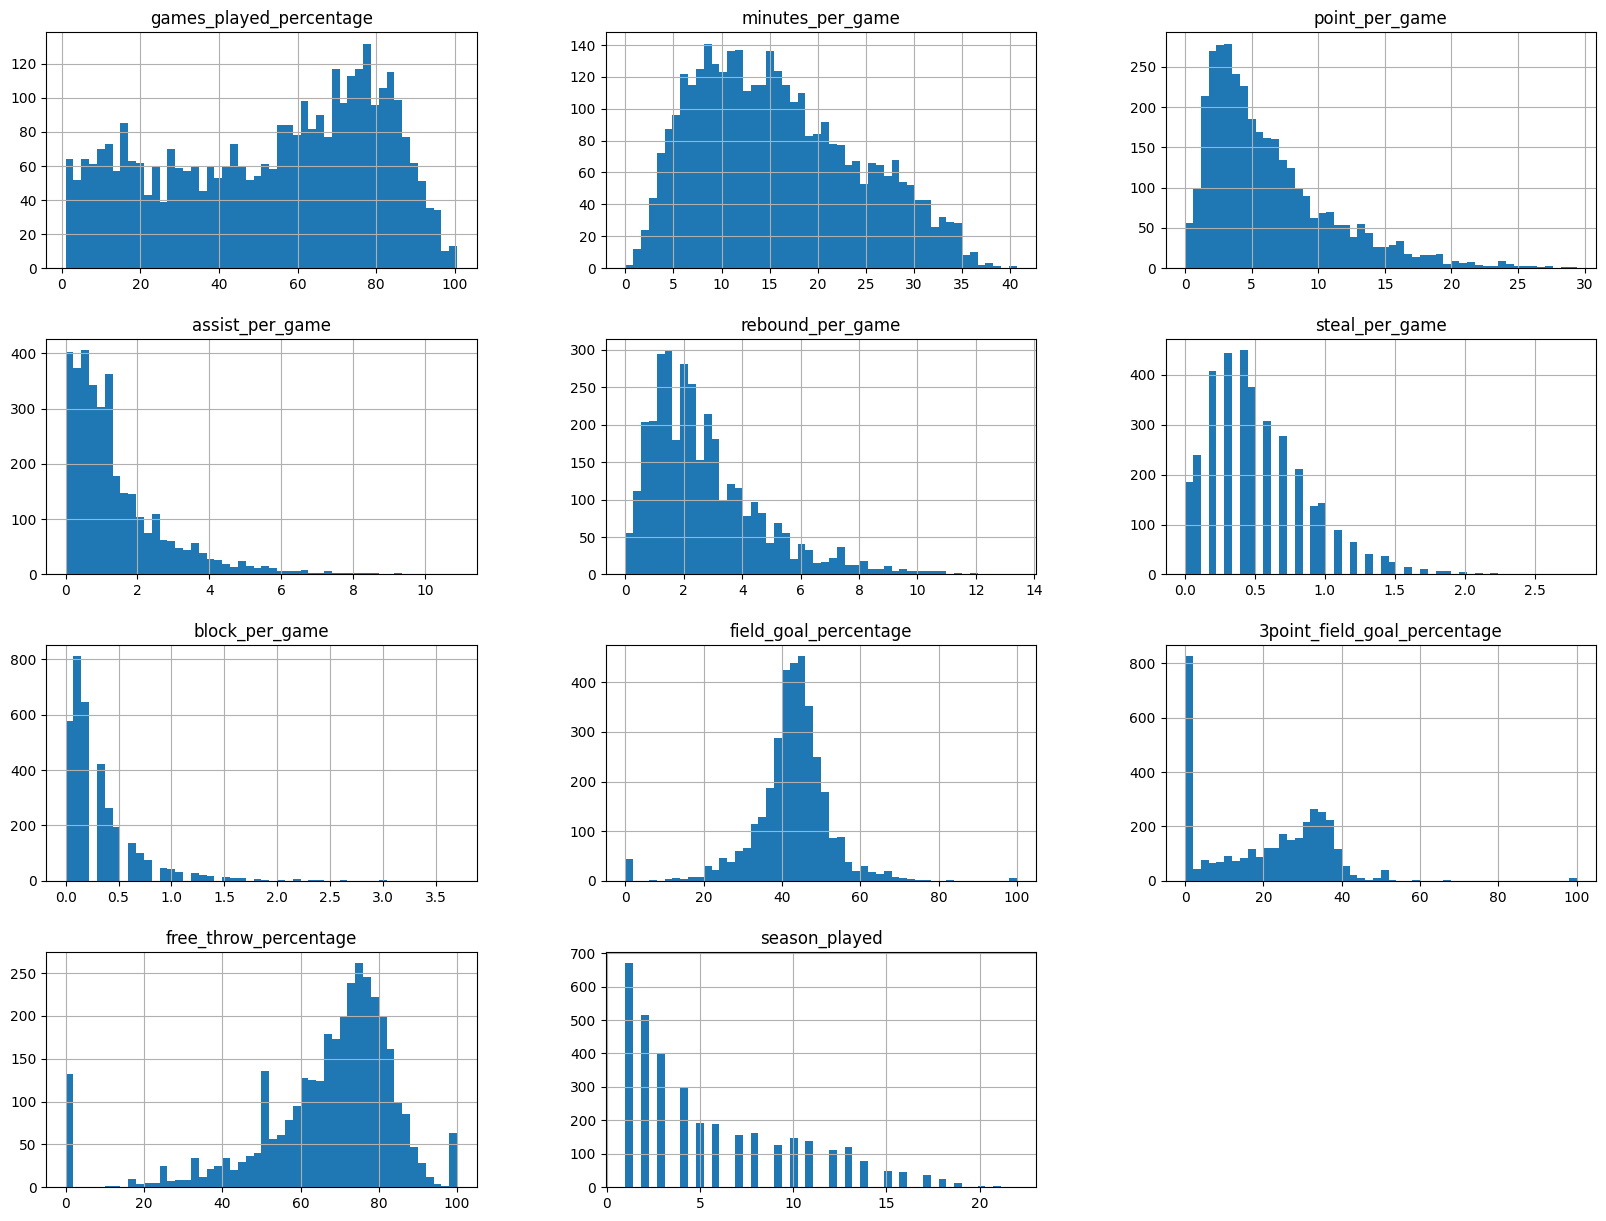

In [45]:
df.drop(columns=["id"]).hist(bins=50, figsize=(20,15))
plt.show()

Histogram for retired players

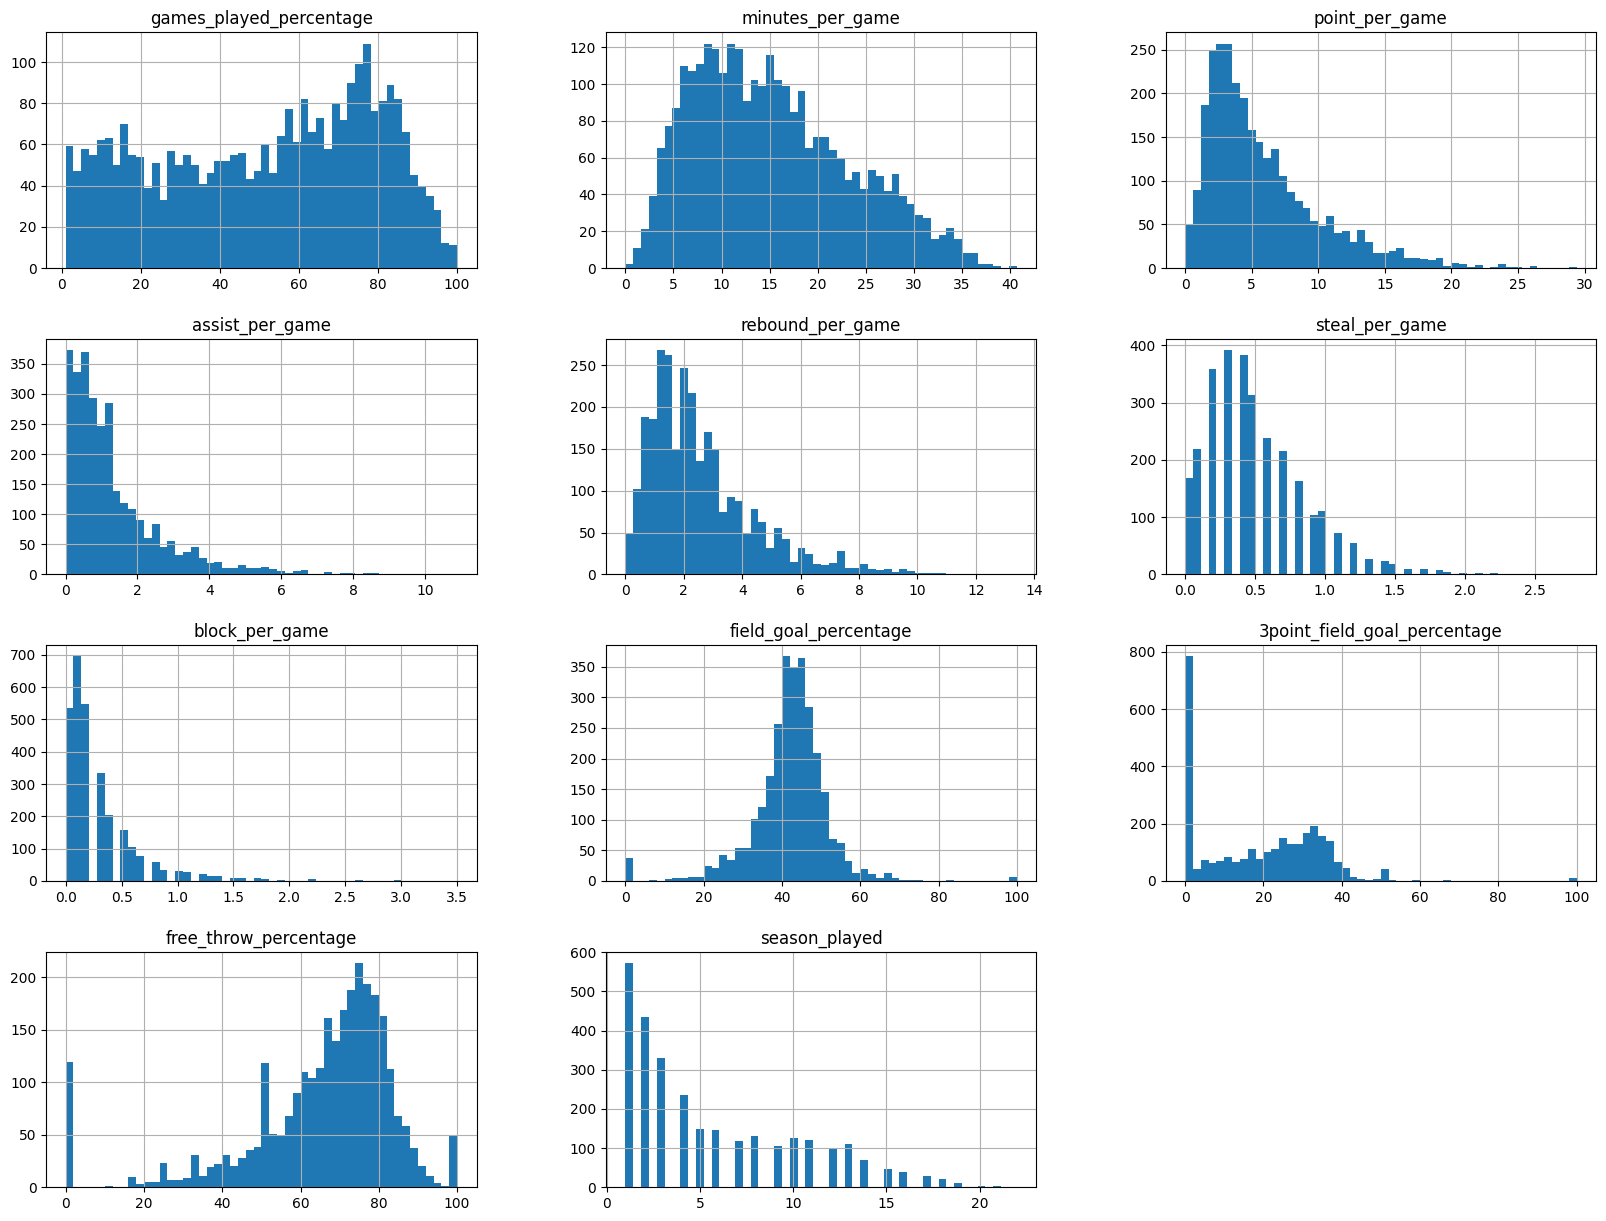

In [46]:
df_retired.drop(columns=["id"]).hist(bins=50, figsize=(20,15))
plt.show()

Histogram for active players

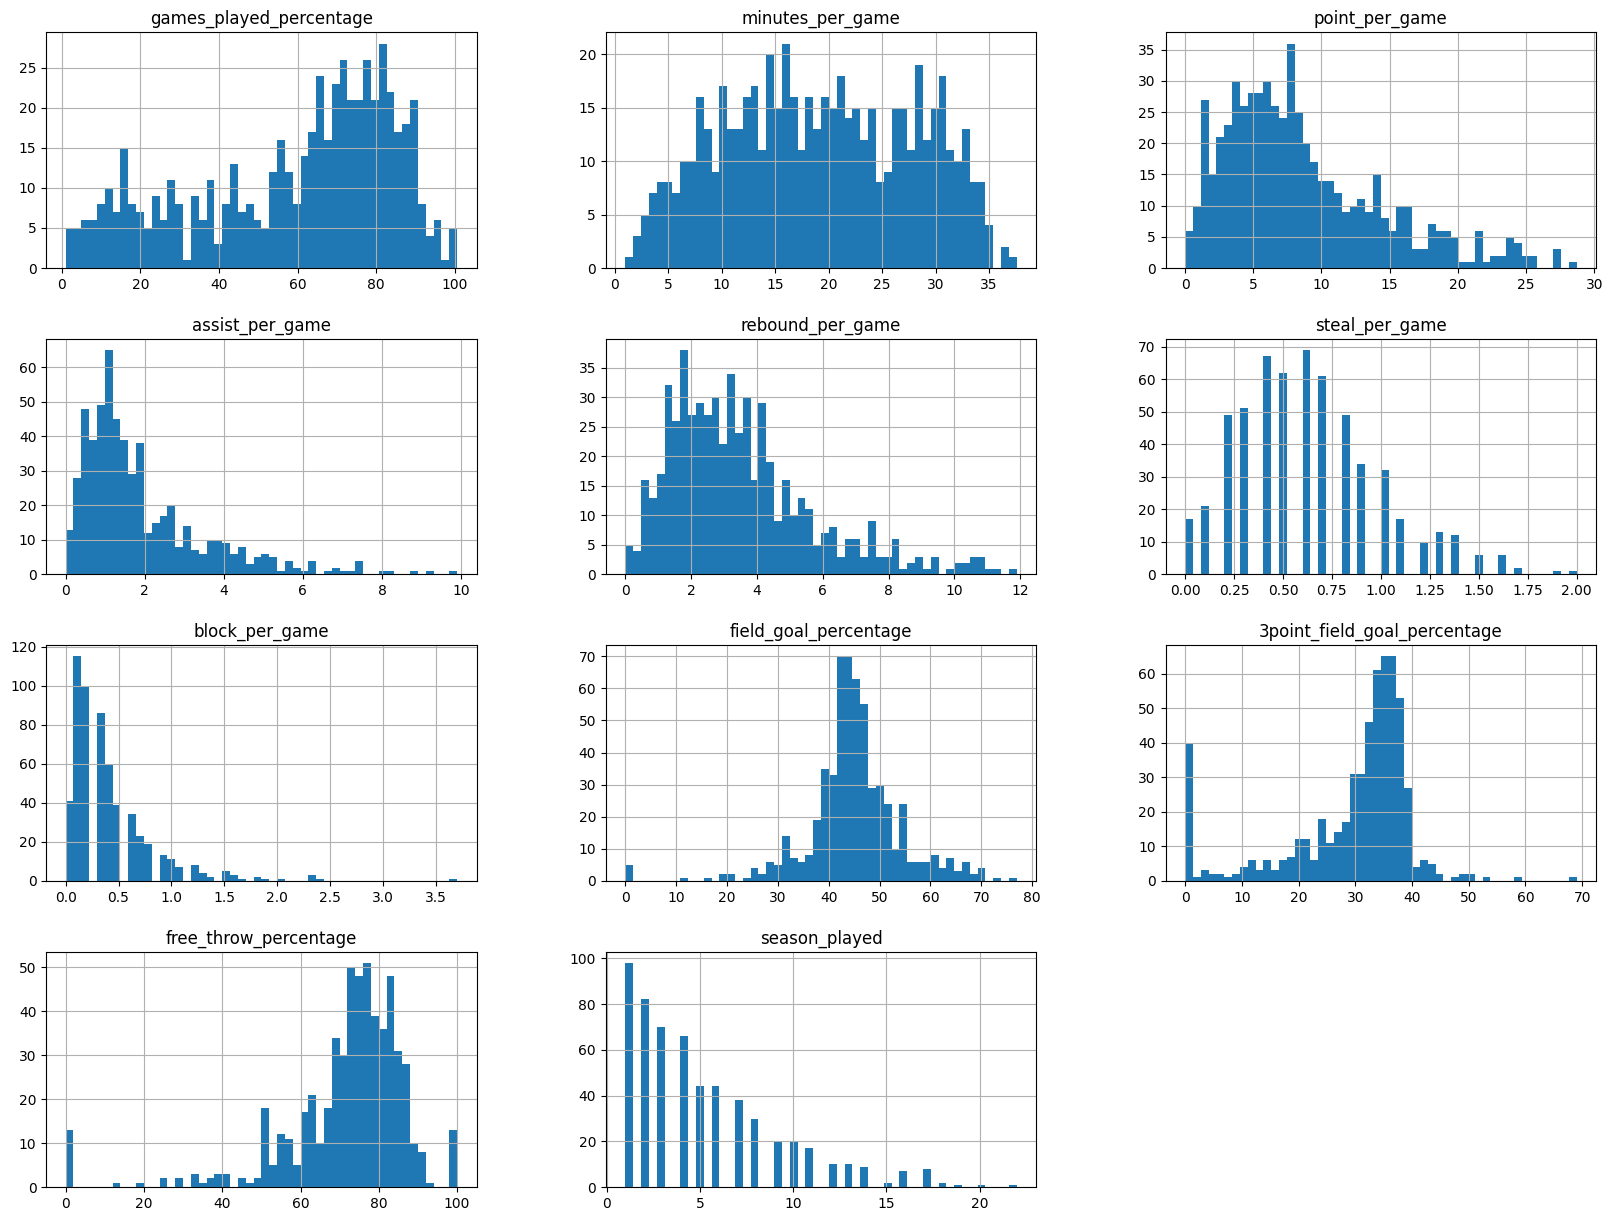

In [47]:
df_active.drop(columns=["id"]).hist(bins=50, figsize=(20,15))
plt.show()

Player career stats trend

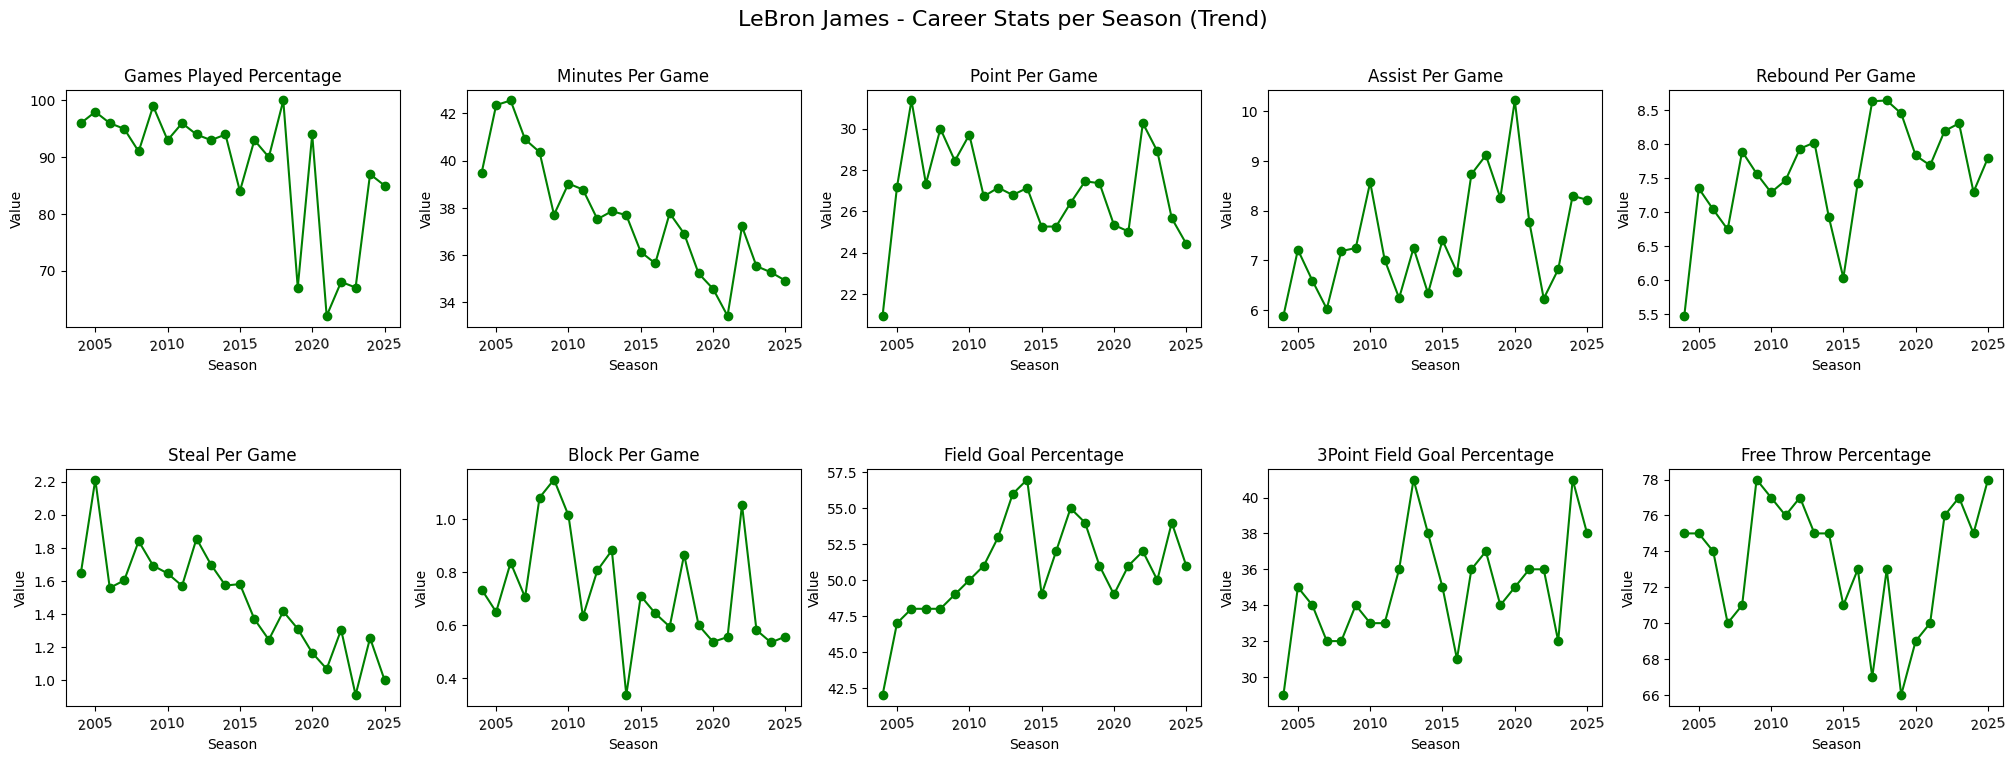

In [48]:
player_name = "LeBron James"
player_df = df_avg[df_avg["name"] == player_name]

stats_plot = ["games_played_percentage", "minutes_per_game", "point_per_game", "assist_per_game", "rebound_per_game", "steal_per_game", "block_per_game", "field_goal_percentage", 
              "3point_field_goal_percentage", "free_throw_percentage"]

ncols = 5
nrows = math.ceil(len(stats_plot) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()

for i, stat in enumerate(stats_plot):
    axes[i].plot(player_df["season"], player_df[stat], marker="o", color="green")
    axes[i].set_title(stat.replace("_", " ").title())
    axes[i].set_xlabel("Season")
    axes[i].set_ylabel("Value")
    axes[i].tick_params(axis="x", rotation=5)


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f"{player_name} - Career Stats per Season (Trend)", fontsize=16)
plt.subplots_adjust(hspace=0.6)
plt.show()

See player speciality

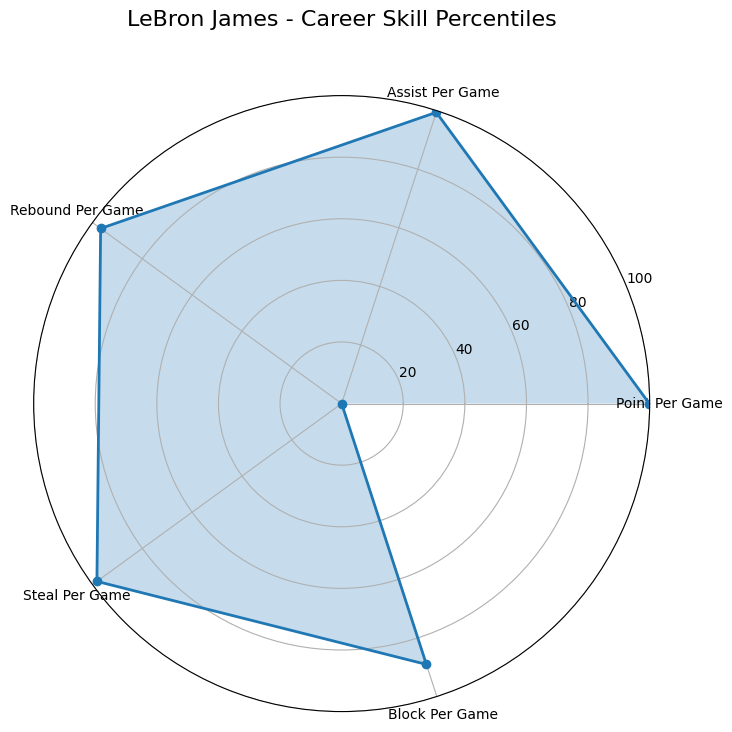

In [49]:
player_name = "LeBron James"          
stats = ["point_per_game", "assist_per_game", "rebound_per_game", "steal_per_game", "block_per_game"]   

df_percentiles = df_one[stats].rank(pct=True) * 100

df_percentiles['name'] = df_one['name']

player_row = df_percentiles.loc[df_percentiles["name"] == player_name].squeeze()

values = player_row[stats].to_numpy()

angles = np.linspace(0, 2 * np.pi, len(stats), endpoint=False)

angles_loop = np.concatenate((angles, [angles[0]]))
values_loop = np.concatenate((values, [angles[0]]))

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})

ax.plot(angles_loop,values_loop, "o-", linewidth=2)
ax.fill(angles_loop, values_loop, alpha=0.25)

ax.set_thetagrids(angles * 180 / np.pi, [s.replace("_", " ").title() for s in stats])
ax.set_ylim(0, 100)

plt.title(f"{player_name} - Career Skill Percentiles", size=16, y=1.1)
plt.show()

Player similarity plot

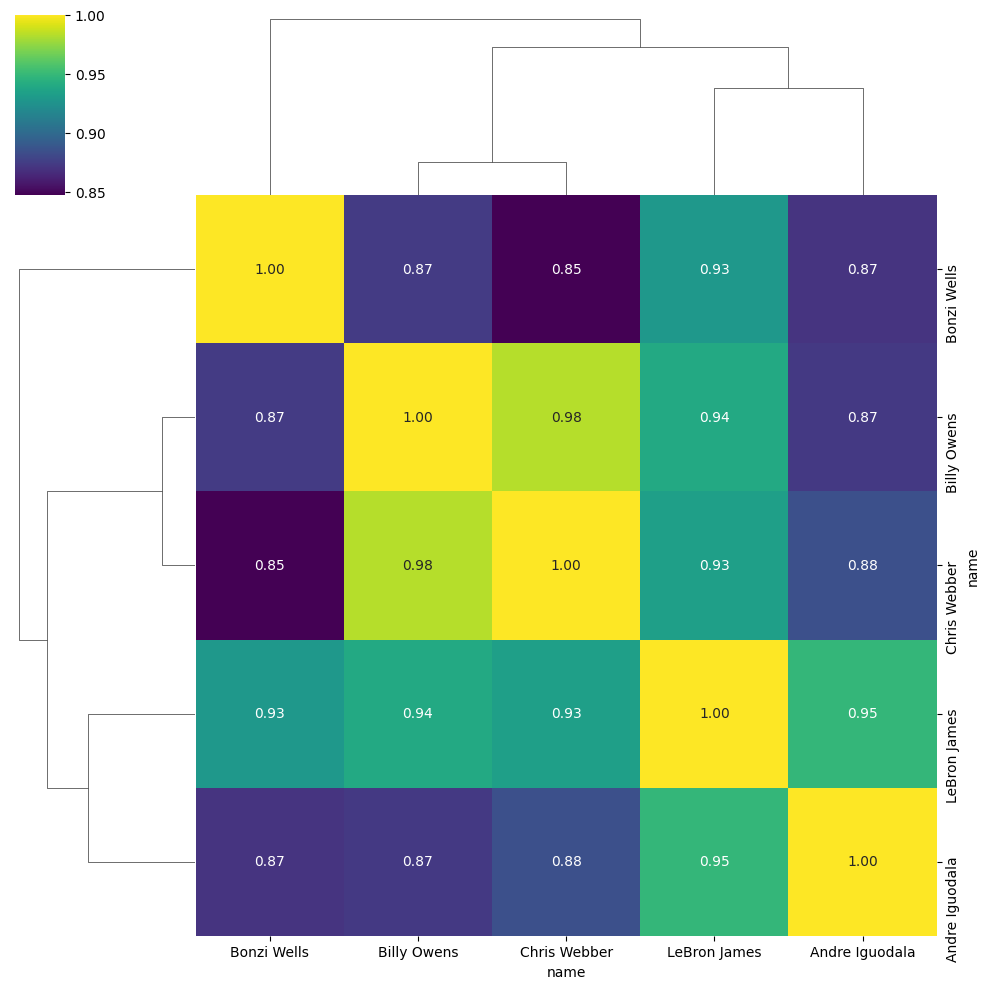

In [50]:
player_name = "LeBron James"          
stats = ["point_per_game", "assist_per_game", "rebound_per_game", "steal_per_game", "block_per_game", "field_goal_percentage", "3point_field_goal_percentage", "free_throw_percentage", "season_played"]   

df_percentiles = df_one[stats].rank(pct=True) * 100
df_percentiles['name'] = df_one['name']
df_percentiles = df_percentiles.set_index('name')


player_similarity = df_percentiles.T.corr()

player_specific_similarity = player_similarity[player_name]

top_5_similar = player_specific_similarity.sort_values(ascending=False).head(5)

top_similar_players = top_5_similar.index

df_similar_players = df_percentiles.loc[top_similar_players]

final_similarity = df_similar_players.T.corr()

sns.clustermap(final_similarity, cmap='viridis', annot=True, fmt=".2f")
plt.show()

Compare two different players stats

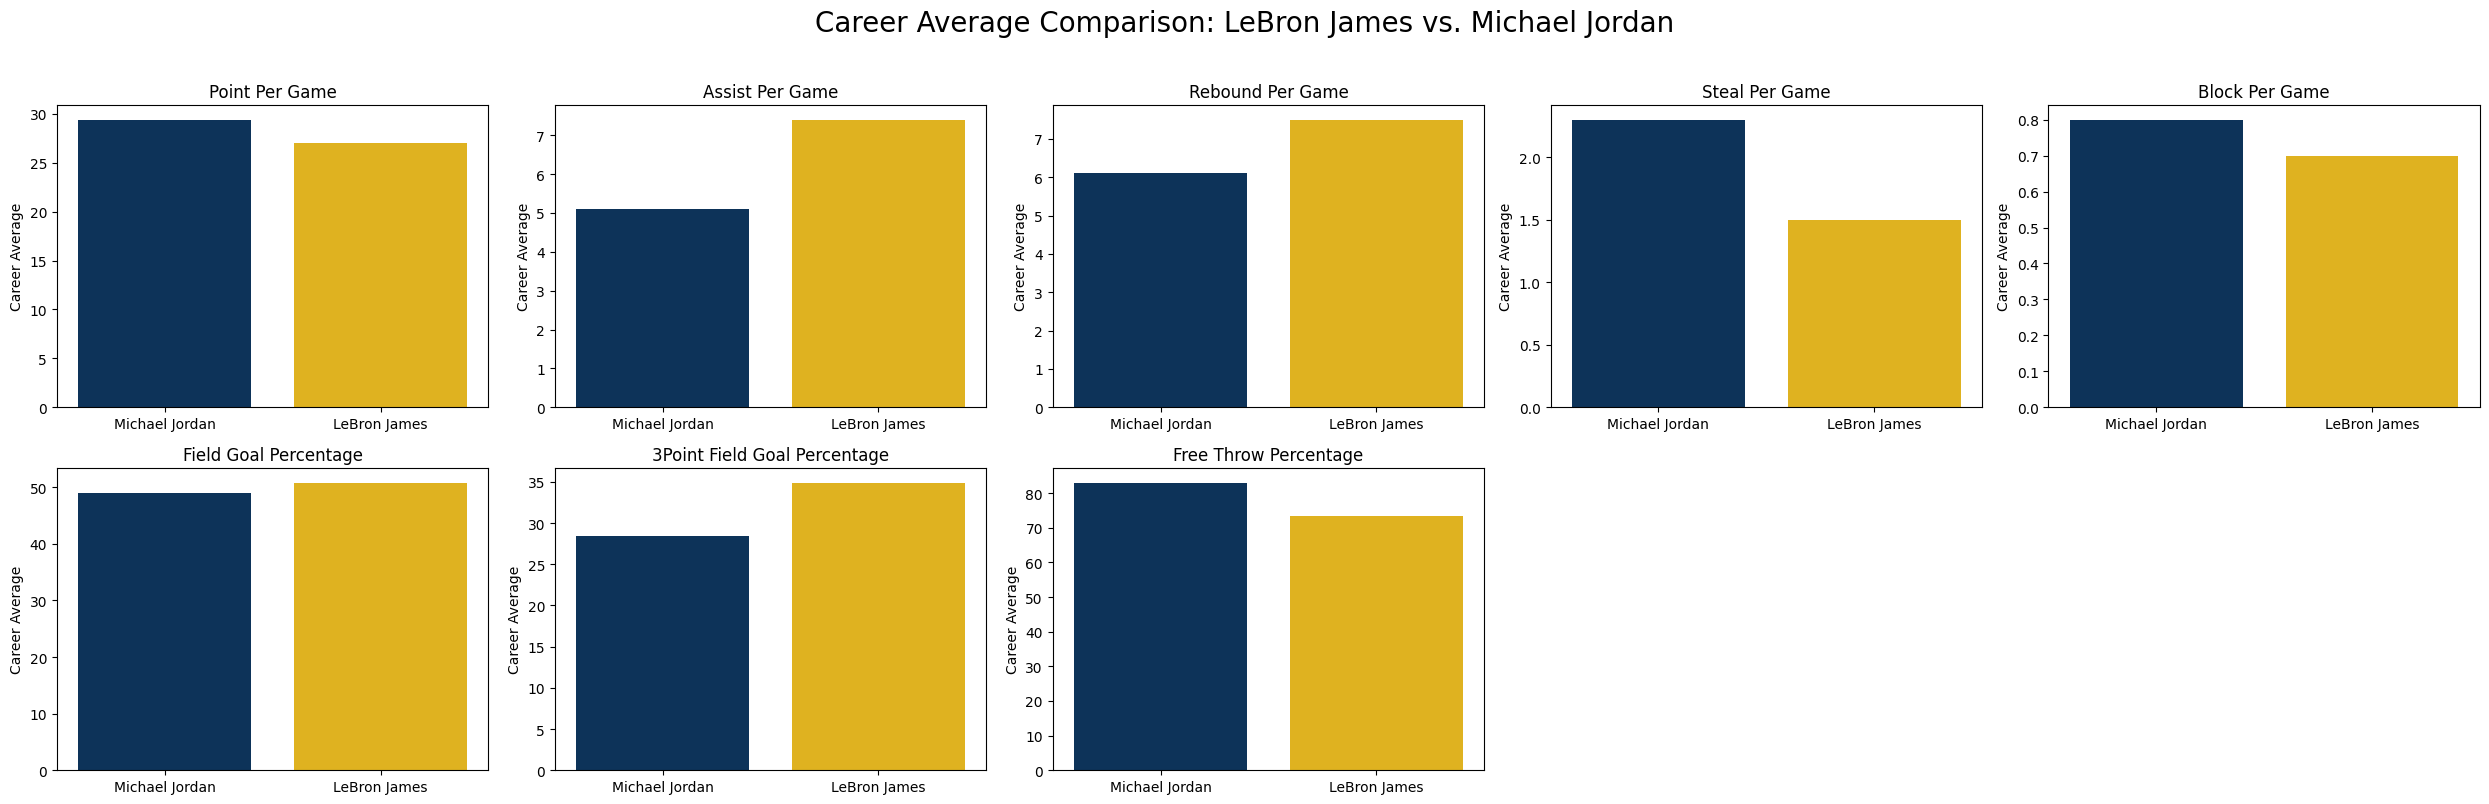

In [51]:
player1_name = "LeBron James"
player2_name = "Michael Jordan"
stats = ["point_per_game", "assist_per_game", "rebound_per_game", "steal_per_game", "block_per_game", "field_goal_percentage", "3point_field_goal_percentage", "free_throw_percentage"]

df_compare = df_one[df_one['name'].isin([player1_name, player2_name])]

ncols = 5
nrows = math.ceil(len(stats) / ncols)

colors = ['#003366', '#FFC300']

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for i, stat in enumerate(stats):
    sns.barplot(data=df_compare, x='name', y=stat, ax=axes[i], palette=colors, hue='name', legend=False)
    axes[i].set_title(stat.replace("_", " ").title())
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Career Average')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Career Average Comparison: {player1_name} vs. {player2_name}', fontsize=20, y=1.0)
plt.tight_layout(rect=[0, 0, 1, 0.98])


Correlation matrix

In [52]:
df_for_corr = df.drop(columns=["id", "is_active"])
cor_matrix = df_for_corr.corr(numeric_only=True)
cor_matrix["season_played"].sort_values(ascending=False)

season_played                   1.000000
minutes_per_game                0.686103
games_played_percentage         0.645810
point_per_game                  0.610910
rebound_per_game                0.552234
steal_per_game                  0.514397
assist_per_game                 0.447489
block_per_game                  0.373511
free_throw_percentage           0.293793
field_goal_percentage           0.260674
3point_field_goal_percentage    0.182235
Name: season_played, dtype: float64

Heatmap

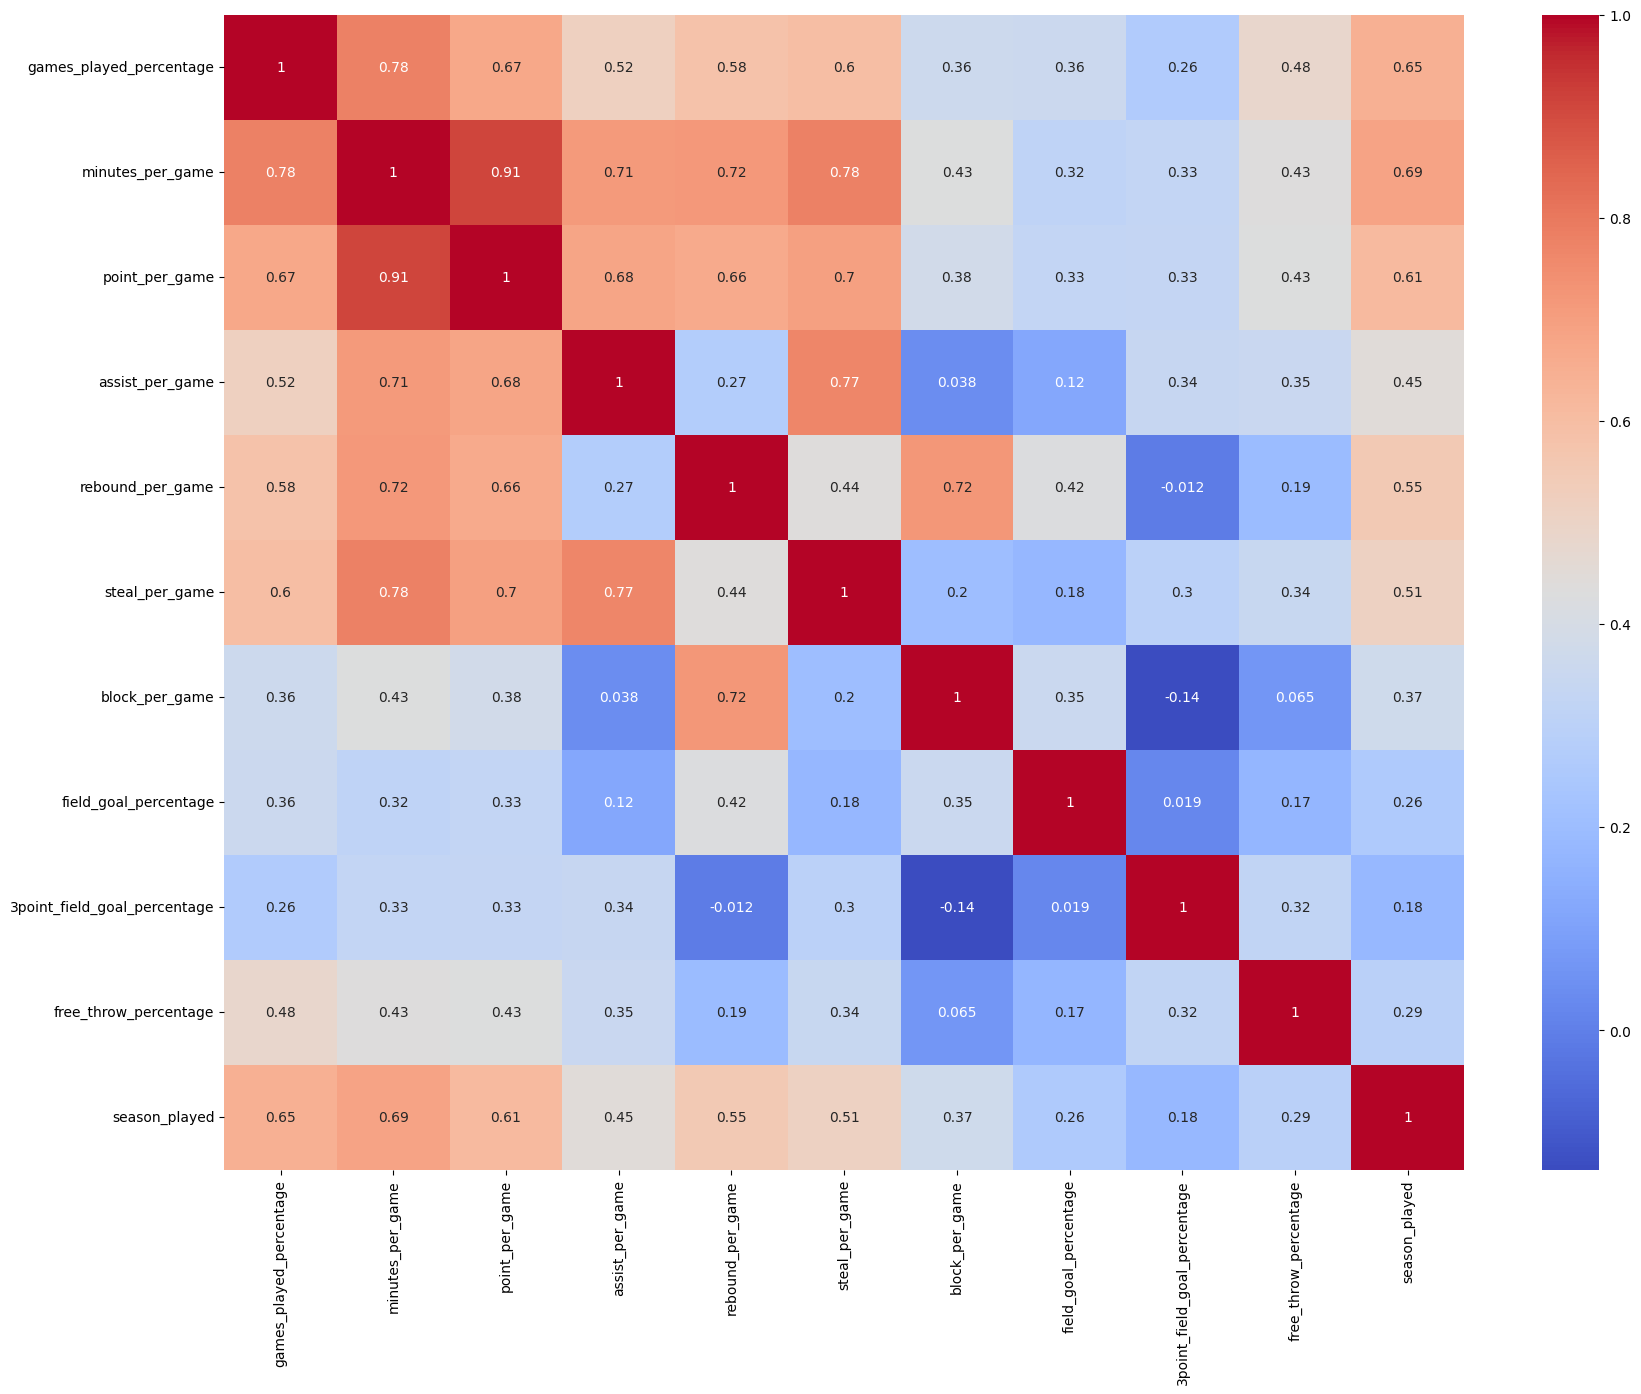

In [53]:
plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(
    cor_matrix,
    annot=True,
    cmap='coolwarm'
)

Modeling preparation

In [54]:
df_proj = df_retired.drop(columns=["id", "name", "is_active"])
df_proj

,games_played_percentage,minutes_per_game,point_per_game,assist_per_game,rebound_per_game,steal_per_game,block_per_game,field_goal_percentage,3point_field_goal_percentage,free_throw_percentage,season_played
0,93.6,28.0,14.0,2.5,2.8,1.1,0.3,47.6,36.5,82.9,14
1,84.1,27.2,8.8,1.6,5.8,1.1,0.3,45.5,16.9,75.6,15
2,77.9,17.9,6.9,1.0,4.5,0.5,0.7,45.3,7.4,79.9,18
3,82.9,22.6,9.2,3.6,1.7,1.1,0.1,47.3,24.6,80.4,14
4,44.0,11.7,4.0,0.7,2.0,0.5,0.2,37.3,22.7,41.3,3
...,...,...,...,...,...,...,...,...,...,...,...
3343,13.0,10.9,2.4,0.5,2.1,0.3,1.6,29.0,0.0,44.0,1
3348,2.0,2.0,2.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,1
3349,12.0,12.6,3.8,0.6,3.8,0.6,0.4,61.0,0.0,40.0,1
3405,7.0,6.7,2.5,0.0,0.8,0.5,0.0,40.0,20.0,100.0,1


Defining Y variable

In [55]:
y = df_proj["season_played"]

Defining X variables

In [56]:
X = df_proj.drop("season_played", axis=1)

Splitting Dataset

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# see length of each set
print("X Training set length:", len(X_train))
print("Y Training set length:", len(y_train))
print("==============================")

print("X Testing set length: ", len(X_test))
print("Y Testing set length: ", len(y_test))

X Training set length: 2321
Y Training set length: 2321
X Testing set length:  581
Y Testing set length:  581


Scale the data

In [59]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Check Skewness

In [60]:
# X variables
skewed_cols = X_train.skew()[abs(X_train.skew()) > 1.0].index
skewed_cols

Index(['point_per_game', 'assist_per_game', 'rebound_per_game',
       'steal_per_game', 'block_per_game', 'free_throw_percentage'],
      dtype='object')

In [61]:
# y variable
if not isinstance(y_train, pd.Series):
    y_train = pd.Series(y_train)

y_skewness = y_train.skew()

print(y_skewness)

if abs(y_skewness) > 1.0:
    print("y_train is highly skewed")
else:
    print("y_train is not highly skewed")

0.89665523226382
y_train is not highly skewed


Log variables that is skewed

In [62]:
X_train_log = X_train.copy()
X_test_log = X_test.copy()

for col in skewed_cols:
    X_train_log[col]= np.log1p(X_train_log[col])
    X_test_log[col] = np.log1p(X_test_log[col])

Scale the log data

In [63]:
scaler = StandardScaler()

X_train_log_scaled = scaler.fit_transform(X_train_log)
X_test_scaled = scaler.transform(X_test_log)

X_train_log_scaled_df = pd.DataFrame(X_train_log_scaled, columns=X_train_log.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_log.columns)

Linear Regression

In [64]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [65]:
linreg_predict_train = linreg.predict(X_train)
linreg_mse_train = mean_squared_error(y_train, linreg_predict_train)
linreg_rmse_train = np.sqrt(linreg_mse_train)

print("Linear Regression RMSE Training: ", linreg_rmse_train.round(2))

Linear Regression RMSE Training:  3.03


In [66]:
linreg_cv = cross_val_score(linreg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
linreg_mse_cv = -linreg_cv
linreg_rmse_cv = np.sqrt(linreg_mse_cv)

print("Linear Regression Average RMSE CV", linreg_rmse_cv.mean().round(2))

Linear Regression Average RMSE CV 3.04


Linear Regression (Log + Scaled Data)

In [67]:
linreg_log_scaled = LinearRegression()
linreg_log_scaled.fit(X_train_log_scaled, y_train)

LinearRegression()

In [68]:
linreg_log_scaled_predict_train = linreg_log_scaled.predict(X_train_log_scaled)
linreg_log_scaled_mse_train = mean_squared_error(y_train, linreg_log_scaled_predict_train)
linreg_log_scaled_rmse_train = np.sqrt(linreg_log_scaled_mse_train)

print("Linear Regression (Log + Scaled) RMSE Training: ", linreg_log_scaled_rmse_train.round(2))

Linear Regression (Log + Scaled) RMSE Training:  3.03


In [69]:
linreg_log_scaled_cv = cross_val_score(linreg_log_scaled, X_train_log_scaled, y_train, scoring="neg_mean_squared_error", cv=10)
linreg_log_scaled_mse_cv = -linreg_log_scaled_cv
linreg_log_scaled_rmse_cv = np.sqrt(linreg_log_scaled_mse_cv)

print("Linear Regression (Log + Scaled Data) Average RMSE CV", linreg_log_scaled_rmse_cv.mean().round(2))

Linear Regression (Log + Scaled Data) Average RMSE CV 3.04


Decision Tree

In [70]:
treereg = DecisionTreeRegressor(random_state=42)
treereg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [71]:
treereg_predict_train = treereg.predict(X_train)
treereg_mse_train = mean_squared_error(y_train, treereg_predict_train)
treereg_rmse_train = np.sqrt(treereg_mse_train)

print("Decision Tree RMSE Training: ", treereg_rmse_train.round(2))

Decision Tree RMSE Training:  0.0


In [72]:
treereg_cv = cross_val_score(treereg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
treereg_mse_cv = -treereg_cv
treereg_rmse_cv = np.sqrt(treereg_mse_cv)

print("Decision Tree Average RMSE CV", treereg_rmse_cv.mean().round(2))

Decision Tree Average RMSE CV 3.9


Random Forest

In [73]:
forestreg = RandomForestRegressor(random_state=42)
forestreg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [74]:
forestreg_predict_train = forestreg.predict(X_train)
forestreg_mse_train = mean_squared_error(y_train, forestreg_predict_train)
forestreg_rmse_train = np.sqrt(forestreg_mse_train)

print("Random Forest RMSE Training: ", forestreg_rmse_train.round(2))

Random Forest RMSE Training:  1.05


In [75]:
forestreg_cv = cross_val_score(forestreg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forestreg_mse_cv = -forestreg_cv
forestreg_rmse_cv = np.sqrt(forestreg_mse_cv)

print("Random Forest Average RMSE CV", forestreg_rmse_cv.mean().round(2))

Random Forest Average RMSE CV 2.81


In [76]:
forestreg_gridsearch_param = {
    'n_estimators': [30, 45, 60],
    'max_features': [8, 10, 12], 
    'max_depth': [5, 10, 15, None], 
    'min_samples_leaf': [1, 5, 10]
}

forestreg_gridsearch = GridSearchCV(forestreg, forestreg_gridsearch_param,scoring="neg_mean_squared_error", cv=10)
forestreg_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [5, 10, 15, None],
                         'max_features': [8, 10, 12],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [30, 45, 60]},
             scoring='neg_mean_squared_error')

In [77]:
forestreg_gridsearch_best_mse = -forestreg_gridsearch.best_score_
forestreg_gridsearch_best_rmse = np.sqrt(forestreg_gridsearch_best_mse)

print("Random Forest Grid Search best RMSE CV score:", forestreg_gridsearch_best_rmse.round(2))

Random Forest Grid Search best RMSE CV score: 2.81


Support Vector Regression

In [78]:
svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

svr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR())])

In [79]:
svr_predict_train = svr.predict(X_train)
svr_mse_train = mean_squared_error(y_train, svr_predict_train)
svr_rmse_train = np.sqrt(svr_mse_train)

print("Support Vector Regression RMSE Training: ", svr_rmse_train.round(2))

Support Vector Regression RMSE Training:  2.83


In [80]:
svr_cv = cross_val_score(svr, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
svr_mse_cv = -svr_cv
svr_rmse_cv = np.sqrt(svr_mse_cv)

print("Support Vector Average RMSE CV", svr_rmse_cv.mean().round(2))

Support Vector Average RMSE CV 2.93


In [81]:
svr_gridsearch_param = {
    'svr__kernel': ['rbf', 'linear'],
    'svr__C': [0.1, 1, 10, 100], 
    'svr__gamma': ['scale', 'auto', 0.1, 1], 
    'svr__epsilon': [0.1, 0.2, 0.3] 
}

svr_gridsearch = GridSearchCV(svr, svr_gridsearch_param,scoring="neg_mean_squared_error", cv=10, verbose=2, n_jobs=-1)
svr_gridsearch.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10, 100],
                         'svr__epsilon': [0.1, 0.2, 0.3],
                         'svr__gamma': ['scale', 'auto', 0.1, 1],
                         'svr__kernel': ['rbf', 'linear']},
             scoring='neg_mean_squared_error', verbose=2)

In [82]:
svr_gridsearch_best_mse = -svr_gridsearch.best_score_
svr_gridsearch_best_rmse = np.sqrt(svr_gridsearch_best_mse)

print("Support Vector Regression Grid Search best RMSE CV score:", svr_gridsearch_best_rmse.round(2))

Support Vector Regression Grid Search best RMSE CV score: 2.84


Support Vector Regression (Log + Scaled Data)

In [83]:
svr_log_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

svr_log_scaled.fit(X_train_log, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR())])

In [84]:
svr_log_scaled_predict_train = svr_log_scaled.predict(X_train_log)
svr_log_scaled_mse_train = mean_squared_error(y_train, svr_log_scaled_predict_train)
svr_log_scaled_rmse_train = np.sqrt(svr_log_scaled_mse_train)

print("Support Vector Regression (Log + Scaled Data) RMSE Training: ", svr_log_scaled_rmse_train.round(2))

Support Vector Regression (Log + Scaled Data) RMSE Training:  2.79


In [85]:
svr_log_scaled_cv = cross_val_score(svr_log_scaled, X_train_log, y_train, scoring="neg_mean_squared_error", cv=10)
svr_log_scaled_mse_cv = -svr_log_scaled_cv
svr_log_scaled_rmse_cv = np.sqrt(svr_log_scaled_mse_cv)

print("Support Vector Regression (Log + Scaled) Average RMSE CV", svr_log_scaled_rmse_cv.mean().round(2))

Support Vector Regression (Log + Scaled) Average RMSE CV 2.86


In [86]:
svr_log_scaled_gridsearch_param = {
    'svr__kernel': ['rbf', 'linear'],
    'svr__C': [0.1, 1, 10, 100], 
    'svr__gamma': ['scale', 'auto', 0.1, 1], 
    'svr__epsilon': [0.1, 0.2, 0.3] 
}

svr_log_scaled_gridsearch = GridSearchCV(svr_log_scaled, svr_log_scaled_gridsearch_param,scoring="neg_mean_squared_error", cv=10, verbose=2, n_jobs=-1)
svr_log_scaled_gridsearch.fit(X_train_log, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10, 100],
                         'svr__epsilon': [0.1, 0.2, 0.3],
                         'svr__gamma': ['scale', 'auto', 0.1, 1],
                         'svr__kernel': ['rbf', 'linear']},
             scoring='neg_mean_squared_error', verbose=2)

In [87]:
svr_log_scaled_gridsearch_best_mse = -svr_log_scaled_gridsearch.best_score_
svr_log_scaled_gridsearch_best_rmse = np.sqrt(svr_log_scaled_gridsearch_best_mse)

print("Support Vector Regression (Log + Scaled) Grid Search best RMSE CV score:", svr_log_scaled_gridsearch_best_rmse.round(2))

Support Vector Regression (Log + Scaled) Grid Search best RMSE CV score: 2.82


Multi Layer Perceptron Regression

In [88]:
mlpreg = keras.models.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1)
])

In [89]:
mlpreg.compile(optimizer='adam', loss='mean_squared_error')
history = mlpreg.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 20.4905 - val_loss: 12.0953
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6541 - val_loss: 11.9291
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.0295 - val_loss: 10.4395
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5884 - val_loss: 10.5331
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0531 - val_loss: 9.9501
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8087 - val_loss: 11.5492
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.6841 - val_loss: 9.5003
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.4186 - val_loss: 9.1975
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1637 - val_loss: 9.8089
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9880 - val_loss: 9.5870
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0585 - val_loss: 9.4916
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8801 - 

In [90]:
mlpreg_mse_train = history.history['loss'][-1]
mlpreg_rmse_train = np.sqrt(mlpreg_mse_train)

print("MLP Regression RMSE Training:", mlpreg_rmse_train.round(2))

MLP Regression RMSE Training: 2.08


In [91]:
mlpreg_mse_val = history.history['val_loss'][-1]
mlpreg_rmse_val = np.sqrt(mlpreg_mse_val)

print("MLP Regression RMSE Validation:", mlpreg_rmse_val.round(2))

MLP Regression RMSE Validation: 3.08


Multi Layer Perceptron (Log + Scaled Data)

In [92]:
mlpreg_log_scaled = keras.models.Sequential([
    keras.layers.Input(shape=(X_train_log_scaled.shape[1],)),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1)
])

In [93]:
mlpreg_log_scaled.compile(optimizer='adam', loss='mean_squared_error')
history = mlpreg_log_scaled.fit(X_train_log_scaled, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 19.4764 - val_loss: 11.1981
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2966 - val_loss: 10.7440
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7576 - val_loss: 10.4313
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3142 - val_loss: 10.0644
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0921 - val_loss: 9.8460
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8520 - val_loss: 9.5786
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5579 - val_loss: 9.6285
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3589 - val_loss: 9.6580
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1639 - val_loss: 9.2263
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0318 - val_loss: 10.2876
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9500 - val_loss: 9.6631
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8073 -

In [94]:
mlpreg_log_scaled_mse_train = history.history['loss'][-1]
mlpreg_log_scaled_rmse_train = np.sqrt(mlpreg_log_scaled_mse_train)

print("MLP Regression (Log + Scaled Data) RMSE Training:", mlpreg_log_scaled_rmse_train.round(2))

MLP Regression (Log + Scaled Data) RMSE Training: 2.09


In [95]:
mlpreg_log_scaled_mse_val = history.history['val_loss'][-1]
mlpreg_log_scaled_rmse_val = np.sqrt(mlpreg_log_scaled_mse_val)

print("MLP Regression (Log + Scaled Data) RMSE Validation:", mlpreg_log_scaled_rmse_val.round(2))

MLP Regression (Log + Scaled Data) RMSE Validation: 3.12


Model Performance Comparison

In [96]:
print("Linear Regression RMSE Training: ", linreg_rmse_train.round(2))
print("Linear Regression Average RMSE CV", linreg_rmse_cv.mean().round(2))
print("Linear Regression (Log + Scaled Data) RMSE Training: ", linreg_log_scaled_rmse_train.round(2))
print("Linear Regression (Log + Scaled Data) Average RMSE CV", linreg_log_scaled_rmse_cv.mean().round(2))
print("=========================")

print("Decision Tree RMSE Training: ", treereg_rmse_train.round(2))
print("Decision Tree Average RMSE CV", treereg_rmse_cv.mean().round(2))
print("=========================")

print("Random Forest RMSE Training: ", forestreg_rmse_train.round(2))
print("Random Forest Average RMSE CV", forestreg_rmse_cv.mean().round(2))
print("Random Forest Grid Search best RMSE CV score:", forestreg_gridsearch_best_rmse.round(2))
print("=========================")

print("Support Vector Regression RMSE Training: ", svr_rmse_train.round(2))
print("Support Vector Average RMSE CV", svr_rmse_cv.mean().round(2))
print("Support Vector Regression Grid Search best RMSE CV score:", svr_gridsearch_best_rmse.round(2))
print("Support Vector Regression (Log + Scaled Data) RMSE Training: ", svr_log_scaled_rmse_train.round(2))
print("Support Vector Regression (Log + Scaled Data) Average RMSE CV", svr_log_scaled_rmse_cv.mean().round(2))
print("Support Vector Regression (Log + Scaled Data) Grid Search best RMSE CV score:", svr_log_scaled_gridsearch_best_rmse.round(2))
print("=========================")

print("MLP Regression RMSE Training:", mlpreg_rmse_train.round(2))
print("MLP Regression RMSE Validation:", mlpreg_rmse_val.round(2))
print("MLP Regression (Log + Scaled Data) RMSE Training:", mlpreg_log_scaled_rmse_train.round(2))
print("MLP Regression (Log + Scaled Data) RMSE Validation:", mlpreg_log_scaled_rmse_val.round(2))
print("=========================")

Linear Regression RMSE Training:  3.03
Linear Regression Average RMSE CV 3.04
Linear Regression (Log + Scaled Data) RMSE Training:  3.03
Linear Regression (Log + Scaled Data) Average RMSE CV 3.04
Decision Tree RMSE Training:  0.0
Decision Tree Average RMSE CV 3.9
Random Forest RMSE Training:  1.05
Random Forest Average RMSE CV 2.81
Random Forest Grid Search best RMSE CV score: 2.81
Support Vector Regression RMSE Training:  2.83
Support Vector Average RMSE CV 2.93
Support Vector Regression Grid Search best RMSE CV score: 2.84
Support Vector Regression (Log + Scaled Data) RMSE Training:  2.79
Support Vector Regression (Log + Scaled Data) Average RMSE CV 2.86
Support Vector Regression (Log + Scaled Data) Grid Search best RMSE CV score: 2.82
MLP Regression RMSE Training: 2.08
MLP Regression RMSE Validation: 3.08
MLP Regression (Log + Scaled Data) RMSE Training: 2.09
MLP Regression (Log + Scaled Data) RMSE Validation: 3.12


The best model is Support Vector Regression (Log + Scaled Data) because it provides the best combination of high performance and excellent reliability.

Define the final model

In [97]:
final_model = svr_log_scaled_gridsearch.best_estimator_

Predict on the test set

In [98]:
predictions = final_model.predict(X_test_log)

In [99]:
final_model_mse = mean_squared_error(y_test, predictions)
final_model_rmse = np.sqrt(final_model_mse)

print("Support Vector Regression (Log + Scaled Data) RMSE Testing", final_model_rmse.round(2))

Support Vector Regression (Log + Scaled Data) RMSE Testing 2.78


Final Model Performance - Support Vector Regression (Log + Scaled Data)

In [100]:
print("Support Vector Regression (Log + Scaled Data) RMSE Training: ", svr_log_scaled_rmse_train.round(2))
print("Support Vector Regression (Log + Scaled Data) Average RMSE CV", svr_log_scaled_rmse_cv.mean().round(2))
print("Support Vector Regression (Log + Scaled Data) Grid Search best RMSE CV score:", svr_log_scaled_gridsearch_best_rmse.round(2))
print("Support Vector Regression (Log + Scaled Data) RMSE Testing", final_model_rmse.round(2))

Support Vector Regression (Log + Scaled Data) RMSE Training:  2.79
Support Vector Regression (Log + Scaled Data) Average RMSE CV 2.86
Support Vector Regression (Log + Scaled Data) Grid Search best RMSE CV score: 2.82
Support Vector Regression (Log + Scaled Data) RMSE Testing 2.78


Save Model

In [101]:
filename = 'nba_seasons_played_model.joblib'
joblib.dump(final_model, filename)

['nba_seasons_played_model.joblib']

Make Predictions

In [102]:
filename = 'nba_seasons_played_model.joblib'
load_model = joblib.load(filename)

In [103]:
new_player_stats = {
    'games_played_percentage': 84.8,
    'minutes_per_game': 33.6,
    'point_per_game': 16.9,
    'assist_per_game': 9.2,
    'rebound_per_game': 4.4,
    'steal_per_game': 2,
    'block_per_game': 0.2,
    'field_goal_percentage': 42,
    '3point_field_goal_percentage': 35,
    'free_throw_percentage': 80,
}

In [104]:
cols_to_log = [
    'point_per_game', 'assist_per_game', 'rebound_per_game', 'steal_per_game', 'block_per_game','free_throw_percentage'
]

In [105]:
new_player_df = pd.DataFrame([new_player_stats])

new_player_df_log = new_player_df.copy()
for col in cols_to_log:
    new_player_df_log[col] = np.log1p(new_player_df_log[col])


prediction = load_model.predict(new_player_df_log)

print(f"This player will have a career of {prediction[0]:.1f} seasons.")

This player will have a career of 13.6 seasons.
